In this notebook we use a bit of Python code to play around with Brownian motion.
This is meant to complement Section 3.2 on Brownian motion from Luke Harmon's
[book on comparative methods](https://lukejharmon.github.io/pcm/chapters/).

First, let's import the Python modules we will be using:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm

_RNG = np.random.default_rng()

plt.rcParams['figure.figsize'] = [9.5, 6]

Next, let's define a function that will evolve a continuous trait through time according to Brownian motion. The basic idea is to take steps through time and simulate the change in the value of the trait by drawing a random number from a normal distribution with a mean of 0 and variance equal to the rate of evolution times the duration of the time step.

In [2]:
def sim_brownian_motion(
        time = 10.0,
        rate = 1.0,
        starting_value = 0.0,
        time_step_size = 0.1,
        rng = _RNG):
    assert time_step_size <= time
    time_points = [0.0]
    trait_values = [starting_value]
    current_time = 0.0
    current_trait_value = starting_value
    while current_time < time:
        time_step = time_step_size
        if (current_time + time_step >= time):
            time_step = time - current_time
        variance = rate * time_step
        std_dev = math.sqrt(variance)
        trait_change = rng.normal(0, std_dev)
        current_trait_value += trait_change
        trait_values.append(current_trait_value)
        current_time += time_step
        time_points.append(current_time)
    return trait_values, time_points

Let's test out our Brownian motion function by simulating a trait for 50 time units, sampling its state every 0.1 time units:

Text(0, 0.5, 'Trait value')

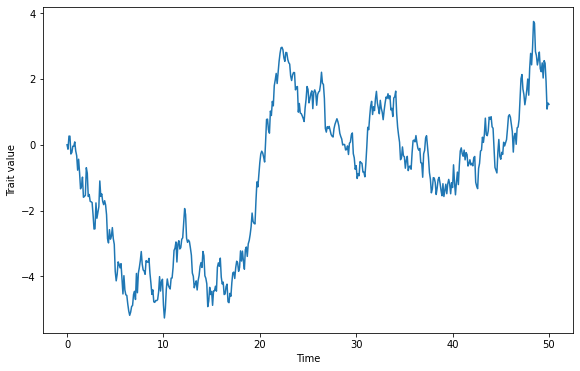

In [3]:
trait_vals, time_points = sim_brownian_motion(time = 50.0)
plt.plot(time_points, trait_vals)
plt.xlabel("Time")
plt.ylabel("Trait value")

Now, let's do that 100 times and look at the variation we see across our simulation replicates:

Text(0, 0.5, 'Trait value')

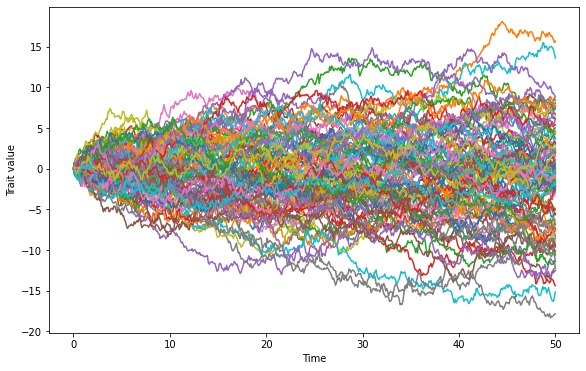

In [4]:
trait_vals_at_end = []
for i in range(100):
    trait_vals, time_points = sim_brownian_motion(time = 50.0)
    trait_vals_at_end.append(trait_vals[-1])
    plt.plot(time_points, trait_vals)
plt.xlabel("Time")
plt.ylabel("Trait value")

In the code above, we kept the final value of the trait after 50 time units for all 100 replicates. Now, let's look at the distribution of those final trait values:

Text(0, 0.5, 'Frequency')

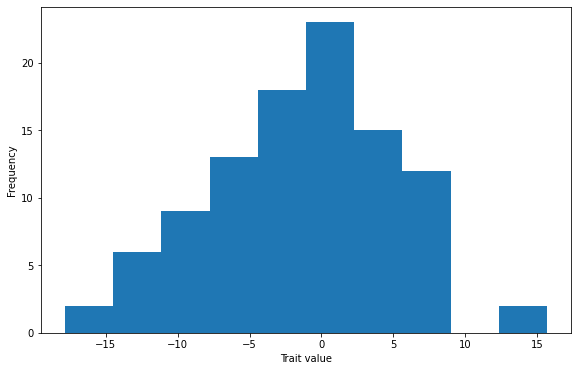

In [5]:
plt.hist(trait_vals_at_end)
plt.xlabel("Trait value")
plt.ylabel("Frequency")

With only 100 replicates, the shape of the distribution is a bit hard to interpret. Let's try 10,000 replicates:

(array([   5.,   97.,  490., 1404., 2625., 2903., 1737.,  602.,  120.,
          17.]),
 array([-27.17973858, -21.86278033, -16.54582208, -11.22886384,
         -5.91190559,  -0.59494735,   4.7220109 ,  10.03896915,
         15.35592739,  20.67288564,  25.98984388]),
 <BarContainer object of 10 artists>)

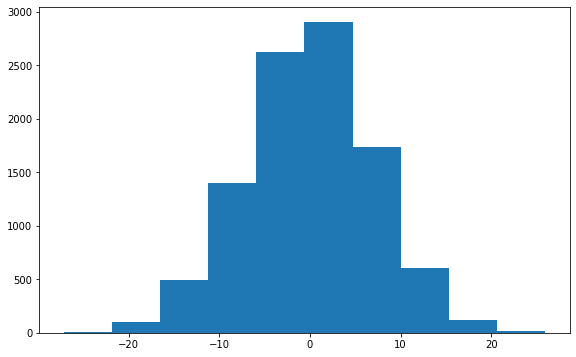

In [6]:
time = 50.0
rate = 1.0
trait_vals_at_end = []
for i in range(10000):
    trait_vals, time_points = sim_brownian_motion(
            time = time,
            rate = rate,
            time_step_size = time)
    trait_vals_at_end.append(trait_vals[-1])
plt.hist(trait_vals_at_end)

That looks normal-ish. We know from the reading that this distribution should be normal with a mean of 0 and a variance of the rate times time ($1.0 \times 50.0$). Let's overlay the expected normal distribution onto our histogram to see if it's a good match

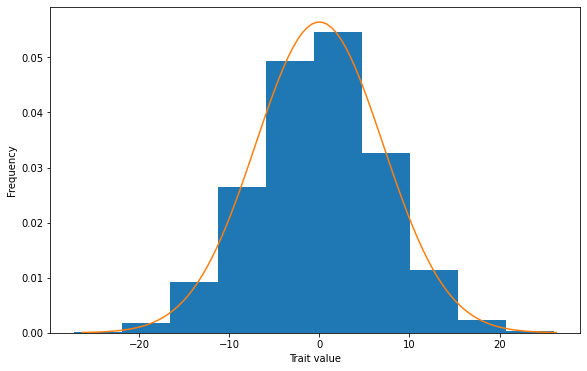

In [7]:
plt.hist(trait_vals_at_end, density = True)
plt.xlabel("Trait value")
plt.ylabel("Frequency")
expected_mean = 0.0
expected_variance = rate * time
expected_std_dev = math.sqrt(expected_variance)
expected_normal_dist = norm(expected_mean, expected_std_dev)
x_min = expected_normal_dist.ppf(0.0001)
x_max = expected_normal_dist.ppf(0.9999)
x = np.linspace(x_min, x_max, 100)
expected_density = expected_normal_dist.pdf(x)
plt.plot(x, expected_density)

In [8]:
def fancy_bm_sim_plots(
        times = [10, 50, 100],
        rates = [1.0, 1.0, 1.0],
        starting_values = None,
        number_of_replicates = 50,
        time_step_size = 0.1,
        rng = _RNG):
    if not starting_values:
        starting_values = [0.0] * len(times)
    assert len(times) == len(rates)
    assert len(times) == len(starting_values)
    for t in times:
        assert time_step_size <= t
    fig = plt.figure(figsize = (9.5, (4.0 * len(times))), constrained_layout = False)
    gs = fig.add_gridspec(
            nrows = len(times),
            ncols = 2,
            width_ratios = (7, 2),
            left = 0.1,
            right = 0.9,
            bottom = 0.1,
            top = 0.9,
            wspace = 0.05,
            hspace = 0.05)
    first_ax = fig.add_subplot(gs[0, 0])
    for i in range(len(times)):
        ax = first_ax
        if i > 0:
            ax = fig.add_subplot(gs[i, 0], sharex = first_ax, sharey = first_ax)
        time = times[i]
        rate = rates[i]
        start_val = starting_values[i]
        vals_at_end = []
        for rep_index in range(number_of_replicates):
            trait_vals, time_points = sim_brownian_motion(
                    time = time,
                    rate = rate,
                    starting_value = start_val,
                    time_step_size = time_step_size,
                    rng = rng)
            vals_at_end.append(trait_vals[-1])
            ax.plot(time_points, trait_vals)
        ax.set_ylabel("Trait value")
        y_hist = fig.add_subplot(gs[i, 1], sharey = ax)
        y_hist.tick_params(axis = "y", labelleft = False)
        if i < len(times) - 1:
            ax.tick_params(axis = 'x', labelbottom = False)
            y_hist.tick_params(axis = 'x', labelbottom = False)
        else:
            ax.set_xlabel("Time")
            y_hist.set_xlabel("Density")
        y_hist.hist(vals_at_end, orientation = 'horizontal', density = True)
        norm_dist = norm(start_val, math.sqrt(rate * time))
        x = np.linspace(norm_dist.ppf(0.001), norm_dist.ppf(0.999), 100)
        y_hist.plot(norm_dist.pdf(x), x)
    return fig

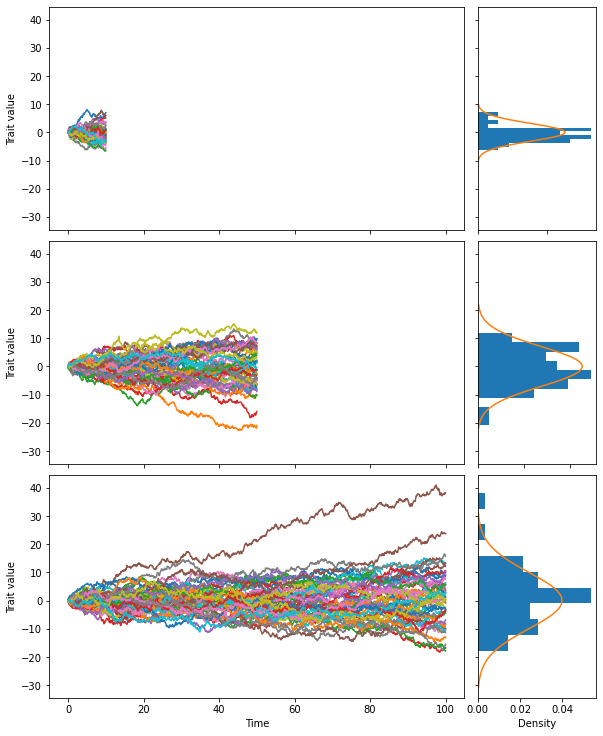

In [9]:
fig = fancy_bm_sim_plots()

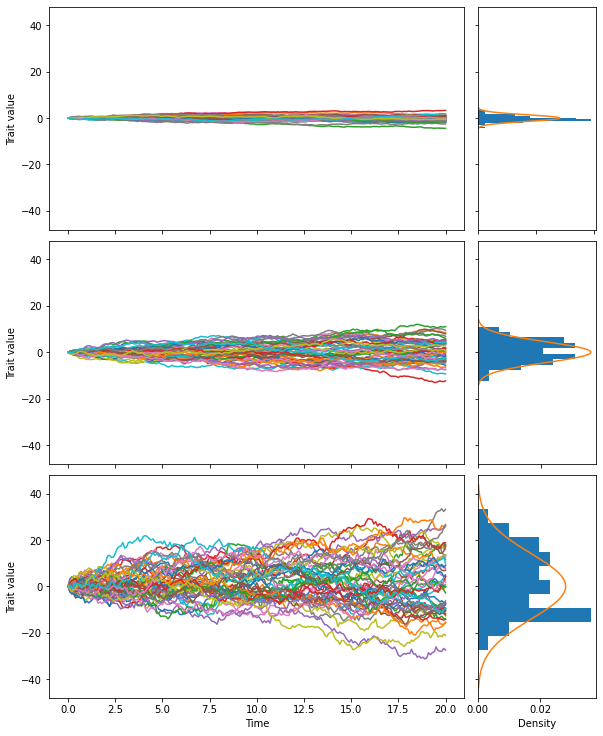

In [10]:
fig = fancy_bm_sim_plots(times = [20, 20, 20], rates = [0.1, 1.0, 10.0])